## Mathematical aspects of Machine Learning: exercise sheet 7

Lecturers: Péter Koltai, Mattes Mollenhauer

This notebook captures some ideas of the main storyline from exercise 2 on sheet 7. 
Instead of solving the actual exercise (which should be solved/presented by you), it shows how kernel properties and the regularization parameter have an influence on the outcome of kernel ridge regression.

We solve the empirical problem 
$$
\min_{f \in H} \sum_{i=1}^n | f(x_i) - y_i |^2 + \alpha \| f \|_H^2 \\
$$
for a strictly positive regularization parameter $\alpha$. Here $H$ is the RKHS induced by some kernel $k$. 
The solution to this problem is given by
$$
f^*(x) := \mathbf{y}^T (K + \alpha I)^{-1} \beta,
$$
where $\mathbf{y} = (y_i)_i \in R^n$ is the target variable column vector, 
$K \in R^{n \times n}$ is the Gramian matrix and $\beta = (k(x_i, x))_i \in R^n$ is the feature evaluation vector.

For simplicity, we use one-dimensional features here. Exercise 2 basically aims at an approximately linear relation between the features (energy content) and macronutrients (fat, sugar, carbohydrates). Therefore we artificially generate data from a linear model perturbed with Gaussian noise in this notebook.

We make use of [scikit-learn](https://scikit-learn.org/stable/index.html), which is one of the standard Python packages for general machine learning tasks and provides a simple interface for [kernel ridge regression](https://scikit-learn.org/stable/modules/kernel_ridge.html).


In [1]:
# we filter warnings, since computations of inverse 
# are ill-conditioned without regularization
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge

%matplotlib inline

In [3]:
np.random.seed(0)

We generate two dimensional data from a linear model with
$$
y_i = m * x_i + n + \epsilon_i,
$$
where the $\epsilon_i$ are i.i.d. normal distributed noise variables.

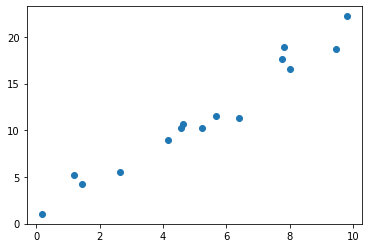

In [4]:
def generate_data(n_samples, m, n, interval, noise_std=1):
    """
    Generate data from a linear model with Gaussian noise.
    """
    epsilon = np.random.randn(n_samples) * noise_std
    X = np.random.rand(n_samples) * interval
    Y = m * X + n + epsilon
    return Y[0, :], X   

Y, X = generate_data(15, np.array([[2]]), 0, 10, noise_std=1.5)
plt.scatter(X, Y)

In [5]:
X_test = np.linspace(0, 10 , 100)

def evaluate_model(model, X=X, Y=Y, X_test=X_test):
    """
    Wrapper function to fit and evaluate sklearn 
    models and perform the needed data reshaping.
    """
    model.fit(X[:,np.newaxis], Y[:, np.newaxis])
    Y_test = model.predict(X_test[:, np.newaxis])
    return Y_test  

In [6]:
alpha = [0, .1, .25, 1 , 3, 10, 100, 1000] # grid of alpha values for experiments

# Linear regression models

We use the standard kernel ridge regression model with a linear kernel here - 
this essentially amounts in a standard linear regression with regularization parameter in the inverse problem.

Since we generated our data with a linear relationship, this model is of course sufficient to describe the data. However, we are still interest in how nonlinear fits may look like.

Note that the weights of the linear model decrease as we increase the regularization parameter - this leads to model misfit due to a bias for too large regularization parameters.

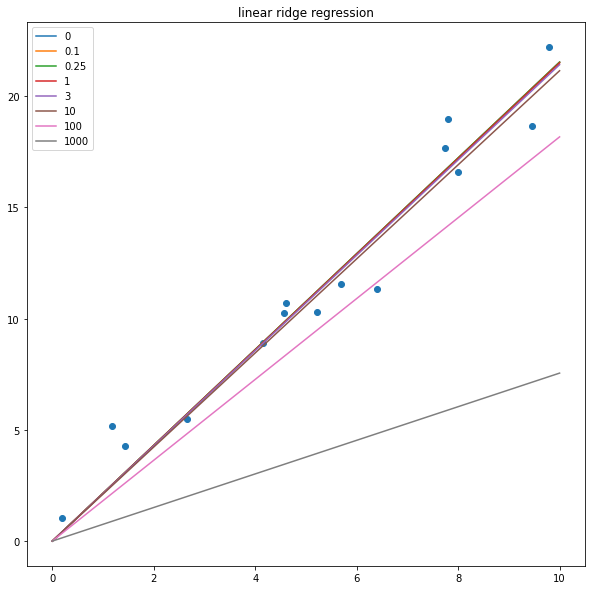

In [7]:
fig = plt.figure(figsize= (10,10))
plt.scatter(X, Y)
for a in alpha:
    model = KernelRidge(alpha=a)
    Y_test = evaluate_model(model, X=X, Y=Y, X_test=X_test)
    plt.plot(X_test, Y_test)
plt.legend(alpha)
plt.title("linear ridge regression")
plt.show()

# Polynomial regression models

For polynomials of a small degree, we get a smooth interpolation of our training data points, which gets even smoother for higher regularization parameters. Note that outside of the domain given by our data, the generalization properties may be poor.

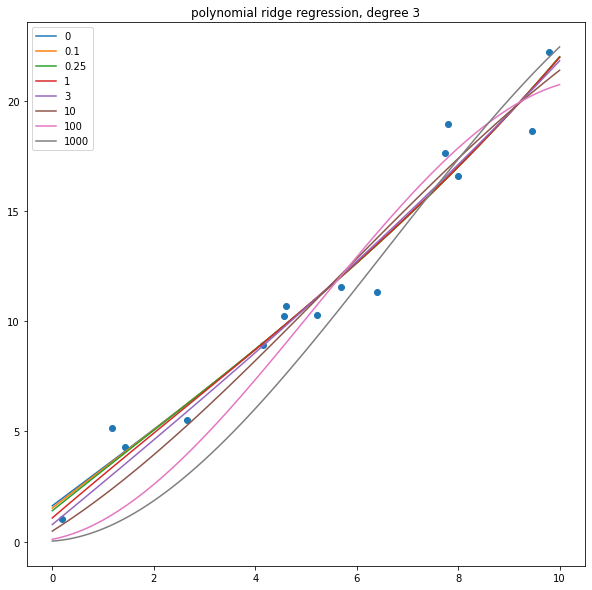

In [8]:
fig = plt.figure(figsize= (10,10))
plt.scatter(X, Y)
for a in alpha:
    model = KernelRidge(alpha=a, kernel="poly", degree = 3)
    Y_test = evaluate_model(model, X=X, Y=Y, X_test=X_test)
    plt.plot(X_test, Y_test)
plt.legend(alpha)
plt.title("polynomial ridge regression, degree 3")
plt.show()

Increasing the polynomial degrees leads to a slightly higher variance of the model. We already guess a misfit outside of the domain of the data.

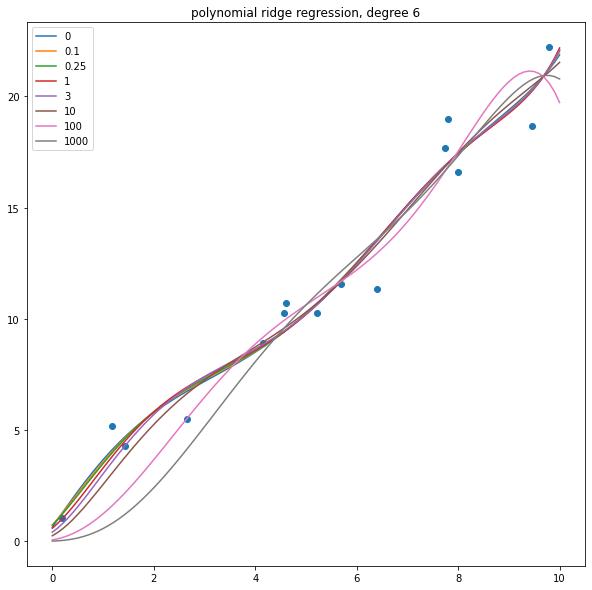

In [9]:
fig = plt.figure(figsize= (10,10))
plt.scatter(X, Y)
for a in alpha:
    model = KernelRidge(alpha=a, kernel="poly", degree = 6)
    Y_test = evaluate_model(model, X=X, Y=Y, X_test=X_test)
    plt.plot(X_test, Y_test)
plt.legend(alpha)
plt.title("polynomial ridge regression, degree 6")
plt.show()

Lets see what happens when we look at a larger domain - the functions values explode.

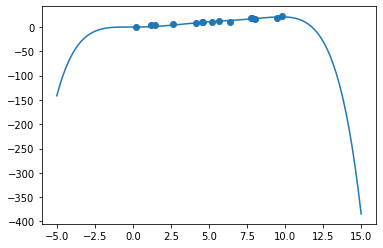

In [10]:
plt.scatter(X, Y)
Y_test = evaluate_model(model, X=X, Y=Y, X_test=np.linspace(-5, 15, 100))
plt.plot(np.linspace(-5, 15, 100), Y_test)

Inceasing the degree even more leads to fits which rapidly explode outside of
the data region. Note that the impact of the regularization parameter becomes negligible.

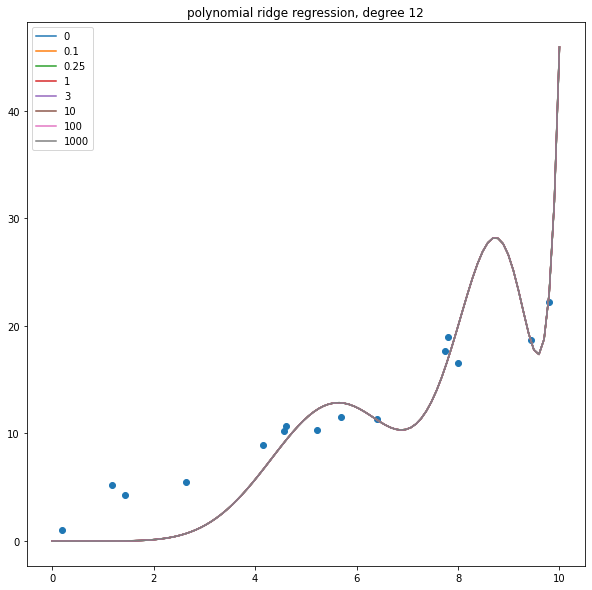

In [11]:
fig = plt.figure(figsize= (10,10))
plt.scatter(X, Y)
for a in alpha:
    model = KernelRidge(alpha=a, kernel="poly", degree = 12)
    Y_test = evaluate_model(model, X=X, Y=Y, X_test=X_test)
    plt.plot(X_test, Y_test)
plt.legend(alpha)
plt.title("polynomial ridge regression, degree 12")
plt.show()

When the degree of the polynomial kernel is large enough, we get a perfect fit on our training data. These models are typically unable to generalize properly.

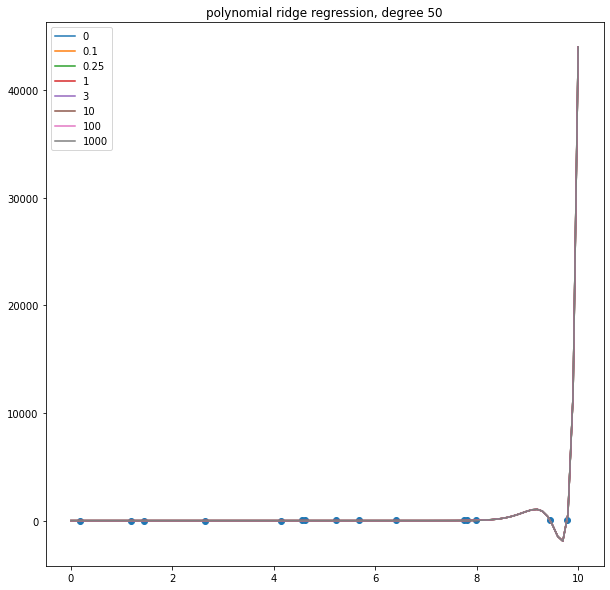

In [12]:
fig = plt.figure(figsize= (10,10))
plt.scatter(X, Y)
for a in alpha:
    model = KernelRidge(alpha=a, kernel="poly", degree = 50)
    Y_test = evaluate_model(model, X=X, Y=Y, X_test=X_test)
    plt.plot(X_test, Y_test)
plt.legend(alpha)
plt.title("polynomial ridge regression, degree 50")
plt.show()

# Gaussian kernel regression

We use the standard radial basis kernel
$$
k(x,y) = \exp(-\gamma \|x-y \|^2 )
$$
for different choices of $\gamma$. Note that large values of $\gamma$ decrease the bandwidth of the kernel and small values increase the bandwidth.

For small $\gamma$, we thus expect more smooth solutions (which may be oversmoothed and imprecise in extreme cases) and for large values of $\gamma$ we expect more
spiky solutions which are prone to overfitting single data points.

For a moderate bandwidth, we can see very well how the regularizer influences the solution.
Without regularization (blue) we get an oscillating solution which fits our data points, but may be unable to generalize. A cautious increase of regularization yields more reasonable fits (orange, green). 
A too large choice of the regularization parameter gradually squeezes the solution to 0.

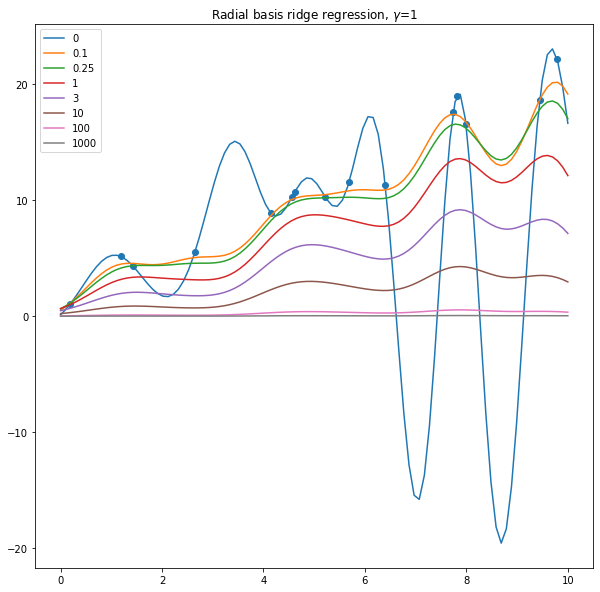

In [13]:
fig = plt.figure(figsize= (10,10))
plt.scatter(X, Y)
for a in alpha:
    model = KernelRidge(alpha=a, kernel="rbf", gamma=1)
    Y_test = evaluate_model(model, X=X, Y=Y, X_test=X_test)
    plt.plot(X_test, Y_test)
plt.legend(alpha)
plt.title("Radial basis ridge regression, $\gamma$=1")
plt.show()

A very small bandwidth leads to heavily oscillating solutions. Again, increasing the regularization parameter squeezes the solutions to 0.

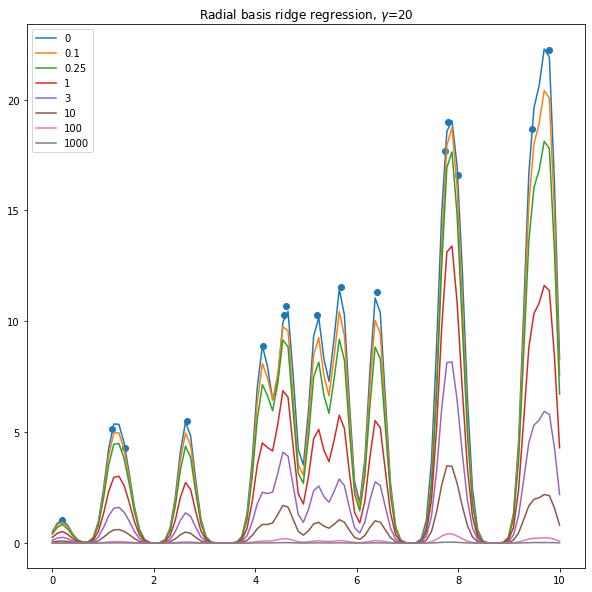

In [14]:
fig = plt.figure(figsize= (10,10))
plt.scatter(X, Y)
for a in alpha:
    model = KernelRidge(alpha=a, kernel="rbf", gamma=20)
    Y_test = evaluate_model(model, X=X, Y=Y, X_test=X_test)
    plt.plot(X_test, Y_test)
plt.legend(alpha)
plt.title("Radial basis ridge regression, $\gamma$=20")
plt.show()

A too small bandwidth leads to oversmoothing even for small choices of regularization parameters.

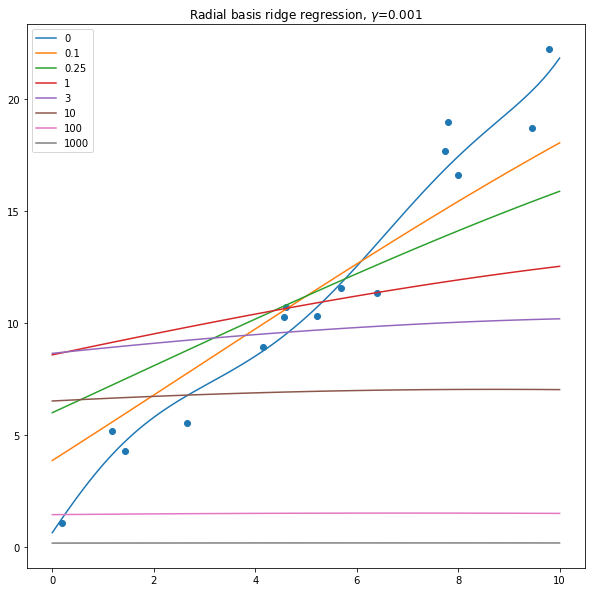

In [15]:
fig = plt.figure(figsize= (10,10))
plt.scatter(X, Y)
for a in alpha:
    model = KernelRidge(alpha=a, kernel="rbf", gamma=0.001)
    Y_test = evaluate_model(model, X=X, Y=Y, X_test=X_test)
    plt.plot(X_test, Y_test)
plt.legend(alpha)
plt.title("Radial basis ridge regression, $\gamma$=0.001")
plt.show()